# SPML HW4: Data Poisoning & Backdoor Attacks

It is **strongly recommended** that you read the entire notebook before you start coding as this will help you better understand the tasks and avoid mistakes and redundant implementations.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
######### Make sure to RUN this cell #########
name = 'Amir Hossein Haji Mohammad Rezaei'
std_id = '99109252'
##############################################

In [ ]:
import numpy as np
from tqdm import trange, tqdm
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset

from torchvision import transforms
from torchvision.datasets.cifar import CIFAR10
from torchvision.models import resnet18, ResNet18_Weights


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# CIFAR10 Dataset (5 points)

Load the CIFAR10 dataset.

In [ ]:
# TODO: Load the CIFAR10 dataset
batch_size = 128

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

transform_test = transforms.Compose([
    transforms.ToTensor()
    ])

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)


trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f'The trainloader consists of {len(trainloader.dataset)} samples.')
print(f'The testloader consists of {len(testloader.dataset)} samples.')

100%|██████████| 170M/170M [00:04<00:00, 34.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
The trainloader consists of 50000 samples.
The testloader consists of 10000 samples.


# Pre-Trained ResNet18 (5 points)

Load the pre-trained resnet18 architecture from torchvision.

In [ ]:
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.feature_extractor = nn.Sequential(
            *list(resnet18(weights=ResNet18_Weights.DEFAULT).children())[:-2]
            )
        self.fc = nn.Linear(512, 10)

    def get_features(self, x):
        features = self.feature_extractor(x)
        return torch.flatten(features, start_dim=1)

    def forward(self, x):
        logits = self.fc(self.get_features(x))
        return logits

In [ ]:
# TODO: Load the pre-trained model
clean_model = ResNet18().to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]


In [ ]:
clean_model.load_state_dict(torch.load('/content/drive/MyDrive/clean_model.pt'))

<ipython-input-7-fabaa554fafa>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  clean_model.load_state_dict(torch.load('/content/drive/MyDrive/clean_model.pt'))


<All keys matched successfully>

# Fine-tuning ResNet18 (5 points)

Train and fine-tune the model on CIFAR10 data.

In [ ]:
def train_model(model, loader, optimizer, criterion, n_epochs=30):
    # TODO: Train the model on the loader for n_epochs

    for epoch in range(1, n_epochs + 1):
      model.train()

      num_correct = 0
      total_loss = 0
      total = 0

      with tqdm(iterable=enumerate(loader), total=len(loader)) as pbar:
        for i, (img, label) in pbar:
          img = img.to(device)
          label = label.to(device)

          optimizer.zero_grad()
          out = model(img)
          loss = criterion(out, label)
          loss.backward()
          optimizer.step()

          num_correct += torch.sum(torch.softmax(out, dim=1).argmax(dim=1) == label).item()
          total_loss += loss.item()
          total += img.shape[0]

      acc = num_correct / total
      avg_loss = total_loss / total

      print(f'train: epoch {epoch}: acc: {acc}, avg loss: {avg_loss}')

In [ ]:
# TODO: Define the optimizer, criterion and train the model

criterion = nn.CrossEntropyLoss()

optimizer = Adam(clean_model.parameters(), lr=0.01)

train_model(clean_model, trainloader, optimizer, criterion)

# TODO: Save the model weights for future use

100%|██████████| 391/391 [00:21<00:00, 18.29it/s]

train: epoch 1: acc: 0.23036, avg loss: 0.01692971447467804



100%|██████████| 391/391 [00:21<00:00, 18.09it/s]

train: epoch 2: acc: 0.35586, avg loss: 0.013437406532764434



100%|██████████| 391/391 [00:22<00:00, 17.47it/s]

train: epoch 3: acc: 0.45422, avg loss: 0.011552522256374358



100%|██████████| 391/391 [00:21<00:00, 18.16it/s]

train: epoch 4: acc: 0.53628, avg loss: 0.01001881337761879



100%|██████████| 391/391 [00:20<00:00, 18.67it/s]

train: epoch 5: acc: 0.59088, avg loss: 0.008955281367301941



100%|██████████| 391/391 [00:20<00:00, 18.75it/s]

train: epoch 6: acc: 0.62966, avg loss: 0.008106847007274627



100%|██████████| 391/391 [00:21<00:00, 18.54it/s]

train: epoch 7: acc: 0.65938, avg loss: 0.007516506587266922



100%|██████████| 391/391 [00:22<00:00, 17.71it/s]

train: epoch 8: acc: 0.68066, avg loss: 0.007097112051248551



100%|██████████| 391/391 [00:21<00:00, 18.42it/s]

train: epoch 9: acc: 0.7023, avg loss: 0.006669843163490295



100%|██████████| 391/391 [00:20<00:00, 18.97it/s]

train: epoch 10: acc: 0.71376, avg loss: 0.006396778552532196



100%|██████████| 391/391 [00:20<00:00, 18.75it/s]

train: epoch 11: acc: 0.7261, avg loss: 0.006133655669689178



100%|██████████| 391/391 [00:21<00:00, 18.19it/s]

train: epoch 12: acc: 0.73632, avg loss: 0.005942000634074211



100%|██████████| 391/391 [00:25<00:00, 15.56it/s]

train: epoch 13: acc: 0.74328, avg loss: 0.005705181589126587



100%|██████████| 391/391 [00:20<00:00, 18.87it/s]

train: epoch 14: acc: 0.7572, avg loss: 0.005468025385737419



100%|██████████| 391/391 [00:20<00:00, 18.84it/s]

train: epoch 15: acc: 0.7632, avg loss: 0.005323253356218338



100%|██████████| 391/391 [00:20<00:00, 18.66it/s]

train: epoch 16: acc: 0.76896, avg loss: 0.00516787289917469



100%|██████████| 391/391 [00:22<00:00, 17.19it/s]

train: epoch 17: acc: 0.77316, avg loss: 0.005119262249469757



100%|██████████| 391/391 [00:21<00:00, 18.58it/s]

train: epoch 18: acc: 0.76384, avg loss: 0.005289386739730835



100%|██████████| 391/391 [00:21<00:00, 18.56it/s]

train: epoch 19: acc: 0.7877, avg loss: 0.0047702541923522945



100%|██████████| 391/391 [00:20<00:00, 18.78it/s]

train: epoch 20: acc: 0.7931, avg loss: 0.0046859256529808045



100%|██████████| 391/391 [00:21<00:00, 18.03it/s]

train: epoch 21: acc: 0.79414, avg loss: 0.004632199415564537



100%|██████████| 391/391 [00:22<00:00, 17.27it/s]

train: epoch 22: acc: 0.80274, avg loss: 0.004489664480090141



100%|██████████| 391/391 [00:21<00:00, 18.59it/s]

train: epoch 23: acc: 0.80368, avg loss: 0.0044186457002162935



100%|██████████| 391/391 [00:20<00:00, 18.62it/s]

train: epoch 24: acc: 0.80834, avg loss: 0.004323112771511078



100%|██████████| 391/391 [00:21<00:00, 18.54it/s]

train: epoch 25: acc: 0.81038, avg loss: 0.004275096249580383



100%|██████████| 391/391 [00:26<00:00, 15.01it/s]

train: epoch 26: acc: 0.81634, avg loss: 0.0041406142091751095



100%|██████████| 391/391 [00:21<00:00, 18.60it/s]

train: epoch 27: acc: 0.81834, avg loss: 0.004063993757367134



100%|██████████| 391/391 [00:20<00:00, 18.75it/s]

train: epoch 28: acc: 0.82338, avg loss: 0.003974305721521377



100%|██████████| 391/391 [00:21<00:00, 18.62it/s]

train: epoch 29: acc: 0.82742, avg loss: 0.0039000919783115386



100%|██████████| 391/391 [00:22<00:00, 17.45it/s]

train: epoch 30: acc: 0.81998, avg loss: 0.00404972851216793


In [ ]:
torch.save(clean_model.state_dict(), '/content/drive/MyDrive/clean_model.pt')


# Testing (5 points)

Report the clean accuracy of the model you trained.

In [ ]:
def test_model(model, loader):
    model.eval()
    correct = 0
    total = 0

    with tqdm(iterable=enumerate(loader), total=len(loader)) as pbar:
      for i, (img, label) in pbar:
        img = img.to(device)
        label = label.to(device)

        logit = model(img)
        prob = F.softmax(logit, dim=1)
        correct += torch.sum(prob.argmax(dim=1) == label).item()
        total += img.shape[0]

    avg_acc = correct / total
    return avg_acc

In [ ]:
acc = test_model(clean_model, testloader)
print(f'Clean accuracy on the clean model is {100 * acc:.2f}%')

100%|██████████| 79/79 [00:01<00:00, 45.05it/s]

Clean accuracy on the clean model is 74.79%


# Poisoning Example Generation (20 points)

We want the implement Algorithm 1 from the [Poison Frogs!](https://arxiv.org/abs/1804.00792) paper. The procedure is as follows:


1.   Initialize x: $x_0 \leftarrow b$
2.   Define: $L_p = \| f(x) - f(t) \|^2$
3.   For $i=1$ to `max_iters` do:
  
  3.1. Forward step: $\hat{x}_i = x_{i-1} - \lambda \nabla L_p(x_{i-1})$

  3.2. Backward step: $x_i = \frac{\hat{x}_i + \lambda \beta b}{1 + \beta \lambda}$



In [ ]:
def poisoning_example_generation(model, t, b, lr, beta=0.25, max_iters=1000):
    # TODO: Implement the given algorithm
    b = b.unsqueeze(0).to(device)
    x = b
    t = t.unsqueeze(0).to(device)

    for _ in trange(max_iters):
      x.detach_()
      x.requires_grad = True

      f_x = model(x)
      f_t = model(t)
      loss = torch.norm(f_x - f_t)
      model.zero_grad()
      loss.backward()

      x_hat = x - lr * x.grad.data
      x = (x_hat + lr * beta * b) / (1 + beta * lr)
      x = x.detach().requires_grad_(True)

    return x.squeeze(0)

Visualize the following sample (*don't change the index*). This is the sample we are going to use as our base.

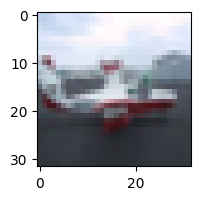

In [ ]:
base = testloader.dataset[int(std_id) % 846][0]
# TODO: Visualize the base image and print its class

fig = plt.figure(figsize=(2, 2))
plt.imshow(base.permute(1, 2, 0).numpy())

What class does the model think this base image belongs to?
Print the logits and the predicted class.

If the base image is misclassified increment the index until you find an image which is correctly classified (*Now change the index if necessary!*).

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
# TODO: Print the output of the model on the base image
def predict(model, sample):
  logit = model(sample.unsqueeze(0).to(device))
  return classes[torch.argmax(torch.softmax(logit, dim=-1), dim=-1)]


predict(clean_model, base)

'plane'

Now choose another image as your target. Visualize this target image and prints its correct label and the models prediction.

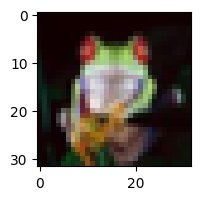

In [ ]:
# TODO: Select, visualize and show the prediction for the target instance
target = testloader.dataset[int(std_id) % 850][0]

fig = plt.figure(figsize=(2, 2))
plt.imshow(target.permute(1, 2, 0).numpy())

In [ ]:
predict(clean_model, target)

'frog'

Now use the `poisoning_example_generation` to generate a poison instane using your base and target images. Visualize this poison instance and print the models prediction on it.

In [ ]:
# TODO: Generate poison instance, visualize it and predict its label

poison = poisoning_example_generation(clean_model, target, base, 0.01)


100%|██████████| 1000/1000 [00:13<00:00, 72.48it/s]


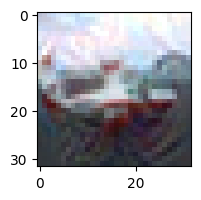

In [ ]:
fig = plt.figure(figsize=(2, 2))
plt.imshow(poison.cpu().detach().permute(1, 2, 0).numpy())

In [ ]:
predict(clean_model, poison)

'frog'

# Poisoned Dataloader (5 points)

Add the poisoned instance to the trainloader and call the resulting loader `poisoned_loader`.

In [ ]:
class ExtendedCIFAR10(torch.utils.data.Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
        self.extra_data = []

    def __len__(self):
        return len(self.original_dataset) + len(self.extra_data)

    def __getitem__(self, idx):
        if idx < len(self.original_dataset):
            return self.original_dataset[idx]
        else:
            return self.extra_data[idx - len(self.original_dataset)]

    def add_data(self, image, label):
        self.extra_data.append((image, label))

In [ ]:
# TODO: Add poison instance to create the poisoned trainloader
poison = poison.cpu().detach()

poisened_set = ExtendedCIFAR10(trainset)
poisened_set.add_data(poison, 0)
poisoned_loader = DataLoader(poisened_set, batch_size=batch_size, num_workers=2, shuffle=True)

print(f'The trainloader consists of {len(trainloader.dataset)} samples.')
print(f'The poisoned trainloader consists of {len(poisoned_loader.dataset)} samples.')

The trainloader consists of 50000 samples.
The poisoned trainloader consists of 50001 samples.


# Poisoned Training (5 points)

 Make a copy of your clean model and call it `attacked_model`. Fine-tune the last layer of the `attacked_model` on the `poisoned_loader`.

In [ ]:
# TODO: Fine-tune the whole model using poisoned trainloader

attacked_model = ResNet18().to(device)
attacked_model.load_state_dict(clean_model.state_dict())
attacked_model.fc = nn.Linear(512, 10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(attacked_model.parameters(), lr=0.01)

train_model(attacked_model, poisoned_loader, optimizer, criterion, 20)

100%|██████████| 391/391 [00:20<00:00, 19.21it/s]

train: epoch 1: acc: 0.8163836723265535, avg loss: 0.00437911973901063



100%|██████████| 391/391 [00:19<00:00, 19.87it/s]

train: epoch 2: acc: 0.8289634207315854, avg loss: 0.0038482988885144174



100%|██████████| 391/391 [00:21<00:00, 18.55it/s]

train: epoch 3: acc: 0.8159036819263614, avg loss: 0.004228816885621173



100%|██████████| 391/391 [00:21<00:00, 18.41it/s]

train: epoch 4: acc: 0.8386432271354572, avg loss: 0.0036613009566819773



100%|██████████| 391/391 [00:20<00:00, 19.38it/s]

train: epoch 5: acc: 0.8421831563368732, avg loss: 0.003538278923070716



100%|██████████| 391/391 [00:20<00:00, 19.50it/s]

train: epoch 6: acc: 0.8454630907381853, avg loss: 0.0034983769377761667



100%|██████████| 391/391 [00:22<00:00, 17.45it/s]

train: epoch 7: acc: 0.8486230275394492, avg loss: 0.0034037727125525315



100%|██████████| 391/391 [00:20<00:00, 19.51it/s]

train: epoch 8: acc: 0.8487230255394892, avg loss: 0.0034332229165167255



100%|██████████| 391/391 [00:20<00:00, 19.52it/s]

train: epoch 9: acc: 0.8510429791404172, avg loss: 0.0033636013223339047



100%|██████████| 391/391 [00:21<00:00, 18.53it/s]

train: epoch 10: acc: 0.8547429051418972, avg loss: 0.0032974559883697423



100%|██████████| 391/391 [00:21<00:00, 18.08it/s]

train: epoch 11: acc: 0.8558028839423212, avg loss: 0.0032287032071934853



100%|██████████| 391/391 [00:19<00:00, 19.62it/s]

train: epoch 12: acc: 0.8047039059218816, avg loss: 0.0045538064018563916



100%|██████████| 391/391 [00:19<00:00, 19.64it/s]

train: epoch 13: acc: 0.8381432371352573, avg loss: 0.003687613793738911



100%|██████████| 391/391 [00:22<00:00, 17.41it/s]

train: epoch 14: acc: 0.8555028899422011, avg loss: 0.0031979285781520506



100%|██████████| 391/391 [00:19<00:00, 19.61it/s]

train: epoch 15: acc: 0.8630827383452331, avg loss: 0.0030731757604079983



100%|██████████| 391/391 [00:20<00:00, 19.14it/s]

train: epoch 16: acc: 0.864042719145617, avg loss: 0.0030256751893088856



100%|██████████| 391/391 [00:21<00:00, 18.38it/s]

train: epoch 17: acc: 0.8665226695466091, avg loss: 0.0030078241006557625



100%|██████████| 391/391 [00:21<00:00, 18.04it/s]

train: epoch 18: acc: 0.8672626547469051, avg loss: 0.002958479015777732



100%|██████████| 391/391 [00:20<00:00, 19.18it/s]

train: epoch 19: acc: 0.869322613547729, avg loss: 0.0029241331880520477



100%|██████████| 391/391 [00:20<00:00, 19.43it/s]

train: epoch 20: acc: 0.869882602347953, avg loss: 0.002908721705076301


In [ ]:
torch.save(attacked_model.state_dict(), '/content/drive/MyDrive/attacked_model.pt')

Report the clean accuracy of the `attacked_model` on the testloader.

In [ ]:
acc = test_model(attacked_model, testloader)
print(f'Clean accuracy on the attacked model is {100 * acc:.2f}%')

100%|██████████| 79/79 [00:01<00:00, 44.72it/s]

Clean accuracy on the attacked model is 78.53%


Now report the models prediction on the base, target and poison instances.

In [ ]:
# TODO: Predict the label of the base, target, and poison
print(f'base label: {predict(attacked_model, base)}')
print(f'target label: {predict(attacked_model, target)}')
print(f'poison label: {predict(attacked_model, poison)}')

base label: plane
target label: frog
poison label: frog


Was the attack successful? Why? What can we do to improve the attack success rate?


`your response:` No, As we fine-tuned the whole model, the feature extractor part of the model learns a new feature embedding map regarding the true label of data samples. Therefore, the embedding of feature of poisoned sample maps its label class and it doesn't cause any misclassification on the target sample.

we can improve the attack by: 1) just training the last layer of the model 2) addming the target images some features of the base class for misclassificationx

# Feature Space Visualization (20 points)

Using `t-SNE` visualize the feature space of the `clean_model` and the `attacked_model` with data from the base and target classes (use different colors for these classes). Visualize the poison instance as well and label it differently (i.e. you can use stars to show poison samples).

***Note: To avoid redundancy, implement this function is such a way that is supports multiple poison samples as opposed to just one!***

In [ ]:
def feature_space_visualization(model, loader, poison_samples, base_class, target_class):

    model.eval()
    features = []
    labels = []
    poison_features = []

    with torch.no_grad():
        for data, label in loader:
            data = data.to(next(model.parameters()).device)
            feature = model.get_features(data)
            features.append(feature.cpu().numpy())
            labels.append(label.cpu().numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)

    with torch.no_grad():
        for poison in poison_samples:
            poison = poison.unsqueeze(0).to(next(model.parameters()).device)
            poison_feature = model.get_features(poison)
            poison_features.append(poison_feature.cpu().numpy())

    poison_features = np.concatenate(poison_features, axis=0)

    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(np.concatenate([features, poison_features], axis=0))

    dataset_features_2d = features_2d[:len(features)]
    poison_features_2d = features_2d[len(features):]

    plt.figure(figsize=(10, 8))

    for class_label, color, label_name in zip([base_class, target_class], ['blue', 'green'], ['Base Class', 'Target Class']):
        class_indices = labels == class_label
        plt.scatter(dataset_features_2d[class_indices, 0], dataset_features_2d[class_indices, 1],
                    label=label_name, alpha=0.6, s=40, c=color)

    plt.scatter(poison_features_2d[:, 0], poison_features_2d[:, 1],
                label='Poison Samples', marker='*', s=200, c='red')

    plt.title('t-SNE Visualization of Feature Space')
    plt.legend()
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True)
    plt.show()


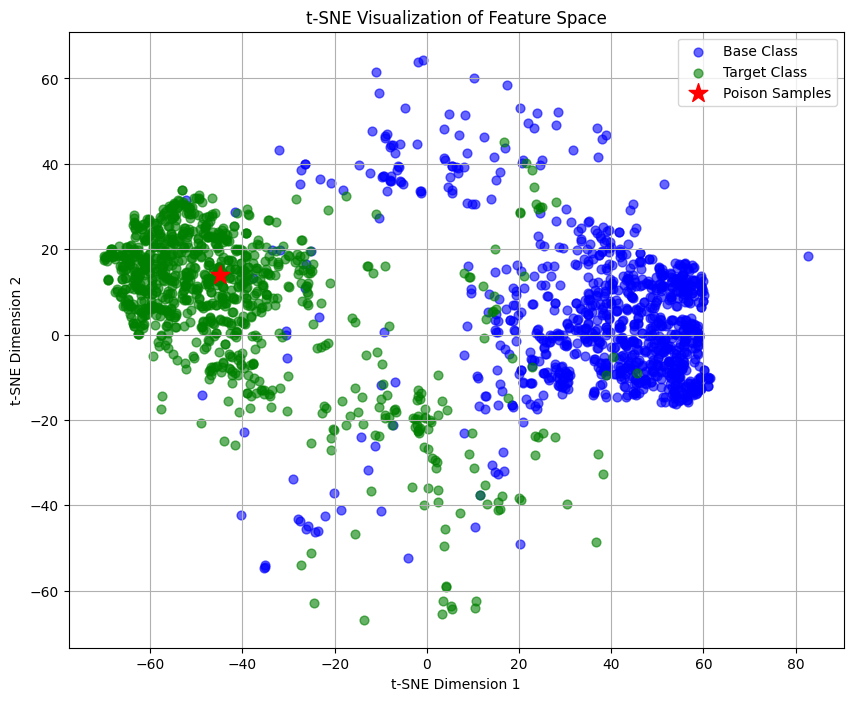

In [ ]:
# TODO: Visualize the clean model

feature_space_visualization(clean_model, testloader, [poison], base_class=0, target_class=6)

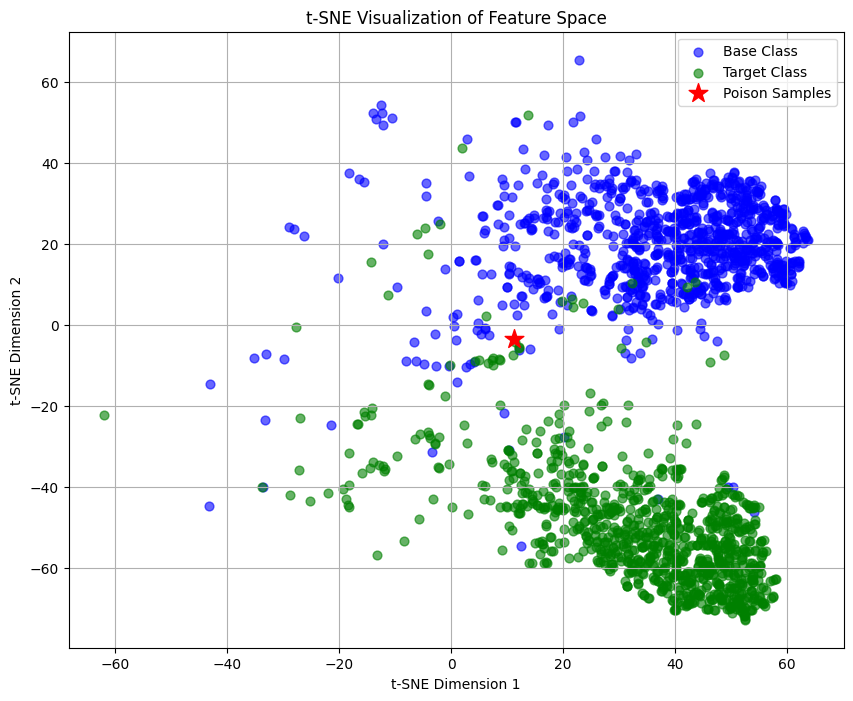

In [ ]:
# TODO: Visualize the attacked model

feature_space_visualization(attacked_model, testloader, [poison], base_class=0, target_class=6)

What do you see? What did you expect? Why?

`your response:`As I explained the reason in previous part, as we expected, the poisoned sample is returned to the base class due to the fact that feature extractor changes here and it relies only on the label of poisoned sample (which is the label of base class)

# Watermark Poisoning (10 points)

A base watermarked image with target opacity $\gamma$ is formed by taking a weighted combination of the base and the target images.
$$t: b \leftarrow \gamma \cdot t + (1 - \gamma ) \cdot b$$

We use this method to boost the power of poison attacks.

In [ ]:
def poisoning_watermark_generation(t, b, gamma=0.3):
    # TODO: Perform watermarking
    return (1 - gamma) * b + gamma * t

Generate 100 poisons by adding a low opacity watermark of the target instance to the base and visualize the results. (*samples must be from the same class*)

In [ ]:
# TODO: Generate 100 poison samples and visualize the results
base_samples = []
target_samples = []

total = 0
for img, label in trainset:
  if total == 200:
    break

  if label == 0:
    if len(base_samples) < 100:
      base_samples.append(img)
      total += 1
  elif label == 6:
    if len(target_samples) < 100:
      target_samples.append(img)
      total += 1

In [ ]:
base = torch.cat(base_samples).reshape(-1, 3, 32, 32)
target = torch.cat(target_samples).reshape(-1, 3, 32, 32)

poison = poisoning_watermark_generation(target, base)

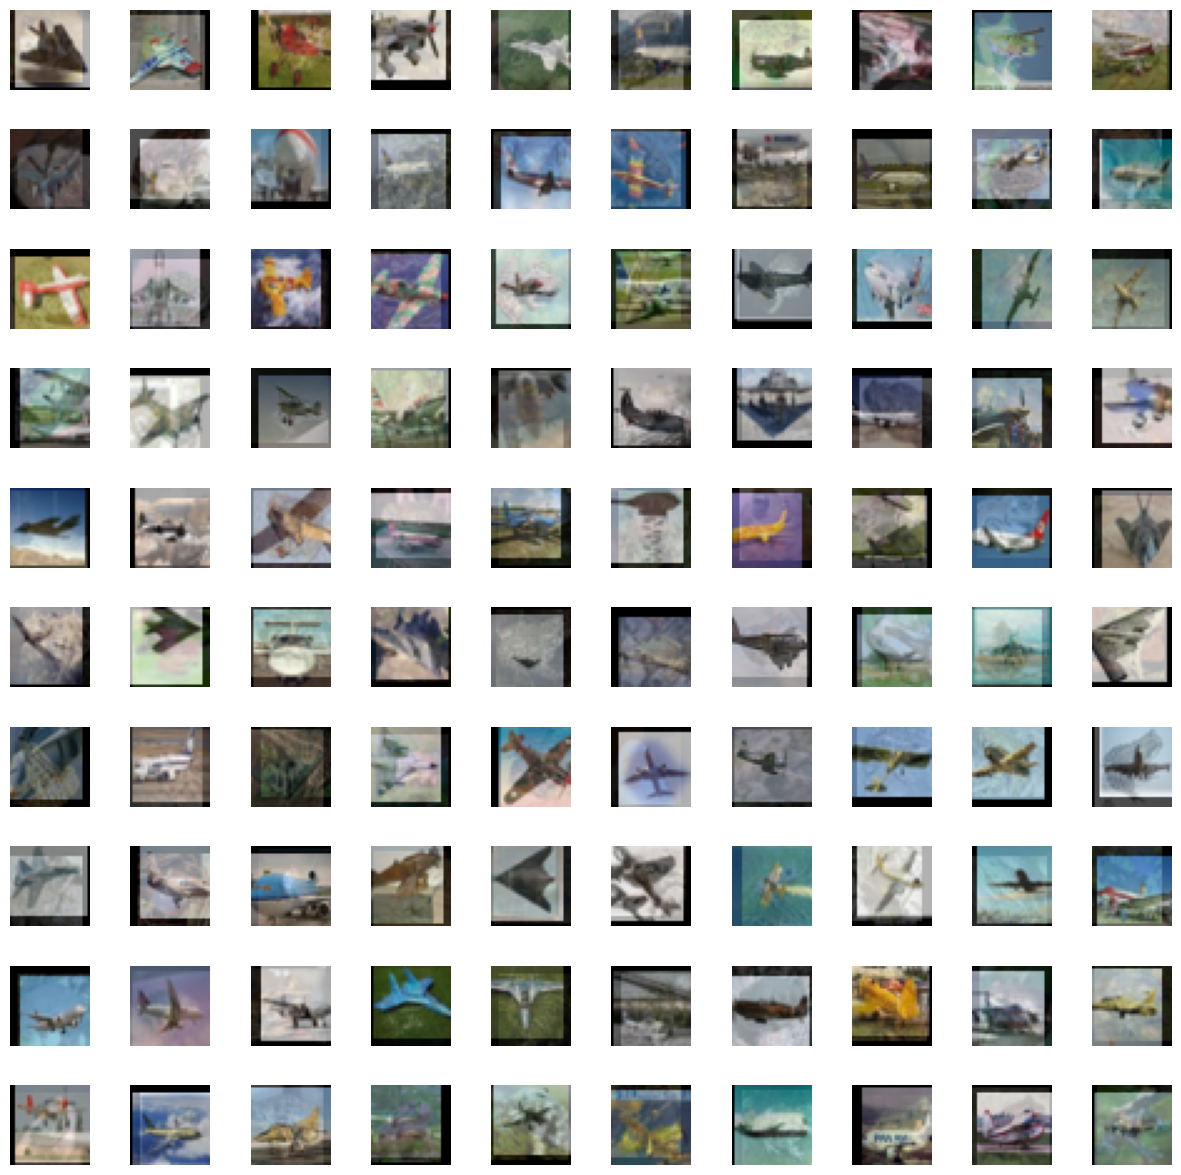

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5, wspace=0.5)


for i, ax in enumerate(axes.flat):
    if i < len(poison):
        ax.imshow(poison[i].permute(1, 2, 0).numpy())
        ax.axis('off')
    else:
        ax.axis('off')


plt.show()

# Watermark Dataloader (5 points)

Add the watermark instances to the trainloader and call the resulting loader `watermark_loader`.

In [ ]:
# TODO: Add watermark instances to create the watermark trainloader
watermark_set = ExtendedCIFAR10(trainset)
for img in poison:
  watermark_set.add_data(img, 0)

watermark_loader = DataLoader(watermark_set, batch_size=batch_size, num_workers=2, shuffle=True)

print(f'The trainloader consists of {len(trainloader.dataset)} samples.')
print(f'The poisoned trainloader consists of {len(poisoned_loader.dataset)} samples.')
print(f'The watermark loader consists of {len(watermark_loader.dataset)} samples.')

The trainloader consists of 50000 samples.
The poisoned trainloader consists of 50001 samples.
The watermark loader consists of 50100 samples.


# Watermark Training (5 points)

Repeat the training steps and report the clean accuracy on the newly trained model. Use another copy of the `clean_model` and train the new network on the `watermark_loader` and report the clean accuracy on this model.

In [ ]:
# TODO: Repeat training steps for the new model
new_attacked_model = ResNet18().to(device)
new_attacked_model.load_state_dict(clean_model.state_dict())
new_attacked_model.fc = nn.Linear(512, 10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(new_attacked_model.parameters(), lr=0.01)

train_model(new_attacked_model, watermark_loader, optimizer, criterion, 20)

100%|██████████| 392/392 [00:21<00:00, 17.88it/s]

train: epoch 1: acc: 0.815249500998004, avg loss: 0.004424096622509871



100%|██████████| 392/392 [00:20<00:00, 19.15it/s]

train: epoch 2: acc: 0.832814371257485, avg loss: 0.003795963240240862



100%|██████████| 392/392 [00:20<00:00, 19.34it/s]

train: epoch 3: acc: 0.8171457085828343, avg loss: 0.004123707790812571



100%|██████████| 392/392 [00:25<00:00, 15.19it/s]

train: epoch 4: acc: 0.8214171656686626, avg loss: 0.004032941458824866



100%|██████████| 392/392 [00:20<00:00, 19.43it/s]

train: epoch 5: acc: 0.8391017964071856, avg loss: 0.0036437868066652567



100%|██████████| 392/392 [00:20<00:00, 19.00it/s]

train: epoch 6: acc: 0.8432734530938124, avg loss: 0.003514023802118625



100%|██████████| 392/392 [00:22<00:00, 17.25it/s]

train: epoch 7: acc: 0.8483233532934131, avg loss: 0.003444952374387406



100%|██████████| 392/392 [00:19<00:00, 19.64it/s]

train: epoch 8: acc: 0.8491816367265469, avg loss: 0.0033859478234649896



100%|██████████| 392/392 [00:20<00:00, 19.17it/s]

train: epoch 9: acc: 0.8509181636726547, avg loss: 0.0033420694201530335



100%|██████████| 392/392 [00:21<00:00, 17.91it/s]

train: epoch 10: acc: 0.841437125748503, avg loss: 0.00362377879118729



100%|██████████| 392/392 [00:20<00:00, 19.12it/s]

train: epoch 11: acc: 0.8355089820359282, avg loss: 0.003724955003299637



100%|██████████| 392/392 [00:20<00:00, 19.24it/s]

train: epoch 12: acc: 0.8534331337325349, avg loss: 0.003279362080875271



100%|██████████| 392/392 [00:20<00:00, 18.77it/s]

train: epoch 13: acc: 0.8564870259481038, avg loss: 0.0031983893586252027



100%|██████████| 392/392 [00:21<00:00, 18.54it/s]

train: epoch 14: acc: 0.8588622754491018, avg loss: 0.003125796964068613



100%|██████████| 392/392 [00:20<00:00, 19.52it/s]

train: epoch 15: acc: 0.8625748502994012, avg loss: 0.0030975032893721453



100%|██████████| 392/392 [00:20<00:00, 18.91it/s]

train: epoch 16: acc: 0.8632135728542915, avg loss: 0.0031071299504853056



100%|██████████| 392/392 [00:22<00:00, 17.60it/s]

train: epoch 17: acc: 0.8663672654690618, avg loss: 0.0030183399128104874



100%|██████████| 392/392 [00:20<00:00, 19.31it/s]

train: epoch 18: acc: 0.8643912175648703, avg loss: 0.003029034065748165



100%|██████████| 392/392 [00:20<00:00, 19.16it/s]

train: epoch 19: acc: 0.862315369261477, avg loss: 0.003124503781814537



100%|██████████| 392/392 [00:21<00:00, 18.59it/s]

train: epoch 20: acc: 0.8541716566866268, avg loss: 0.0032928804645757236


# Watermarking Results (10 points)

Now check if the poisoning attack is successful.

In [ ]:
# TODO: Evaluate the attack
logits = new_attacked_model(target.to(device))
preds = torch.argmax(F.softmax(logits, dim=-1), dim=-1)

i = 0
for p in preds:
  if classes[p] != 'frog':
    i += 1

print(f'succes rate: {i}%')

succes rate: 80%


Using the `feature_space_visualizaion` function you wrote earlier (modify it if necessary) visualize the feature space for this model as well.

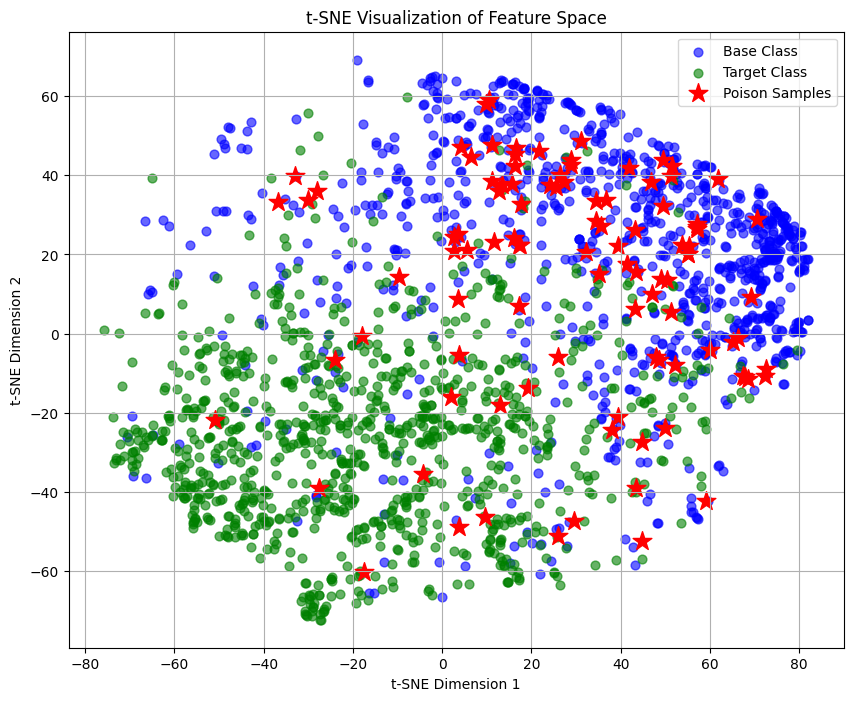

In [ ]:
# TODO: Visualize the attacked model
feature_space_visualization(new_attacked_model, testloader, poison, base_class=0, target_class=6)

Summarize your findings.

`your response:` Here, by watermark poisoning, we could embed the target features in the posined samples with labels of base class. In this case, as we fine-tune the feature extractor of the model, due to the fact that the visual features of target class are presented in the poisoned samples, **the target class distribution along with poisined samples is pulled toward the base class distribution** and as a result, it causes misclassification on the target class samples.